In [285]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import optuna

In [286]:
def info(y_test, y_pred):
    print(f'R²: {r2_score(y_test, y_pred)}')
    print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
    print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')

Берем MAE (основная метрика - среднее значение ошибки). Также используем R², поскольку нам надо видеть насколько "умна" модель относительно среднего значения. RMSE используется для того чтобы видеть влияние крупных ошибок.

In [287]:
def separating_parts(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [288]:
def correlation(correlation_matrix):
    plt.figure(figsize=(20,15))
    sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.show

In [289]:
df = fetch_california_housing(as_frame=True)

In [290]:
df.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [291]:
df['target']

0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: MedHouseVal, Length: 20640, dtype: float64

Целевой признак: MedHouseVal

In [292]:
df['frame'].describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


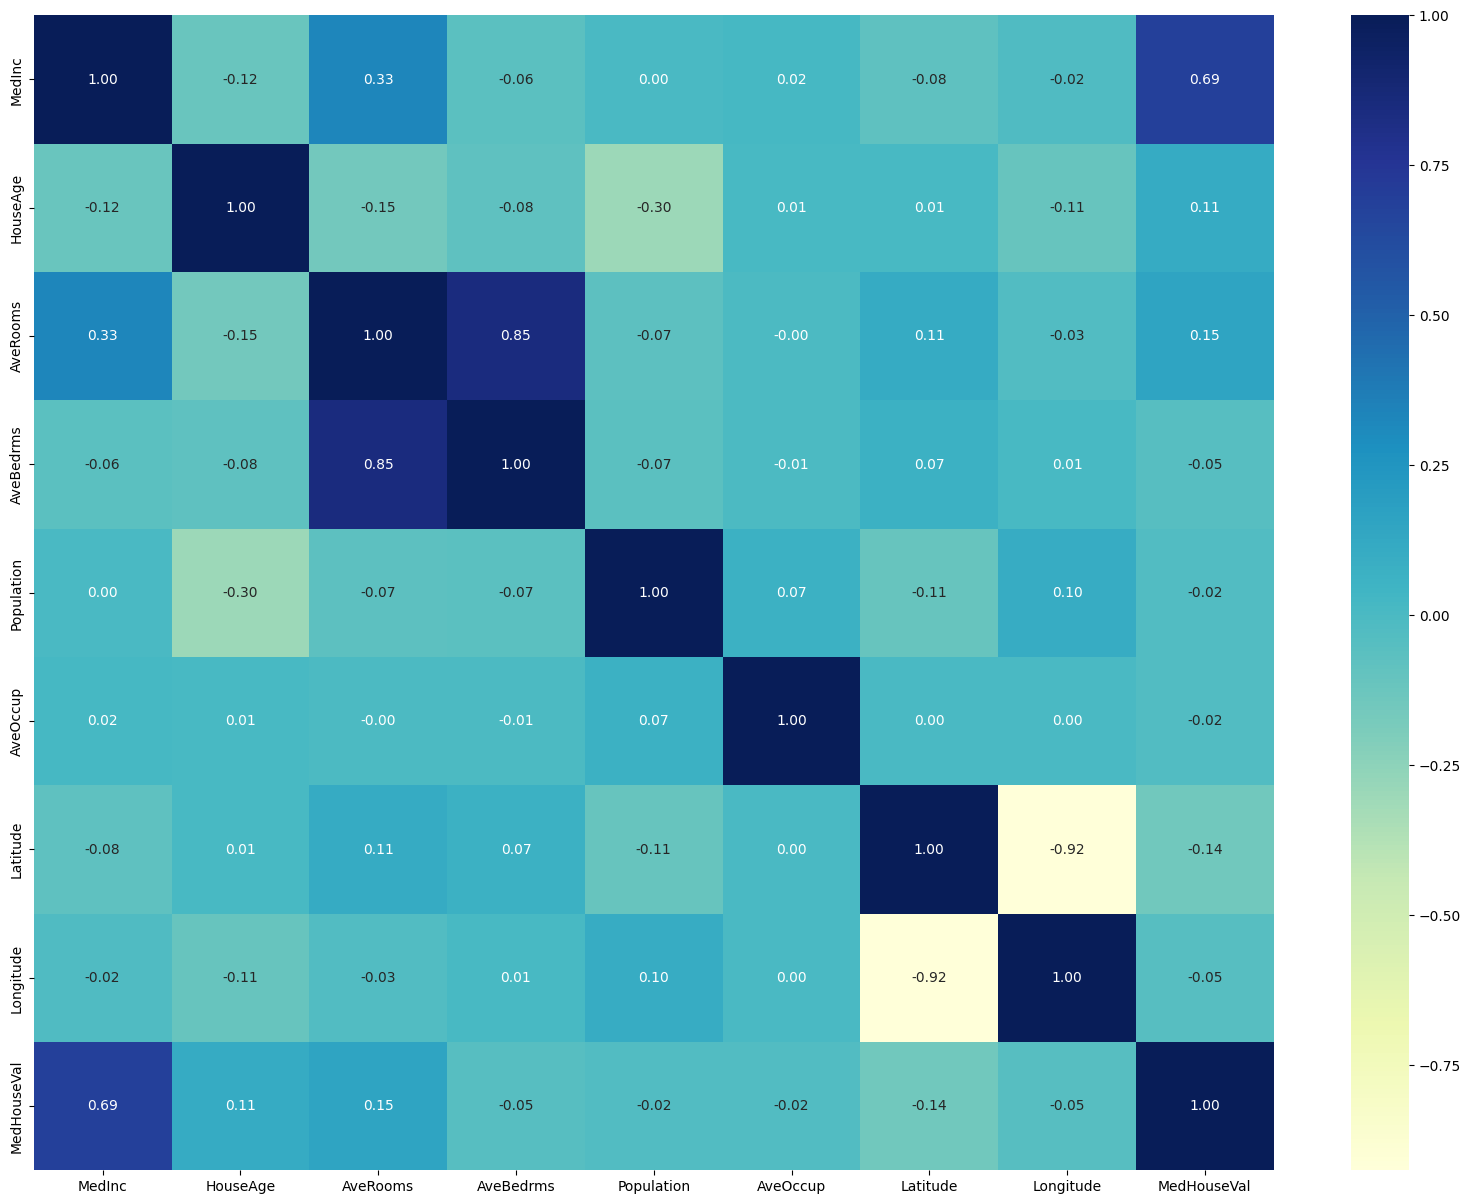

In [293]:
correlation(df['frame'].corr())

In [294]:
frame = df['frame']

Заметим очень сильную корреляцию, равную 0,69. Значит, этот признак очень значим для targetа.

In [295]:
frame['MedIncLog'] = np.log(df['frame']['MedInc'])

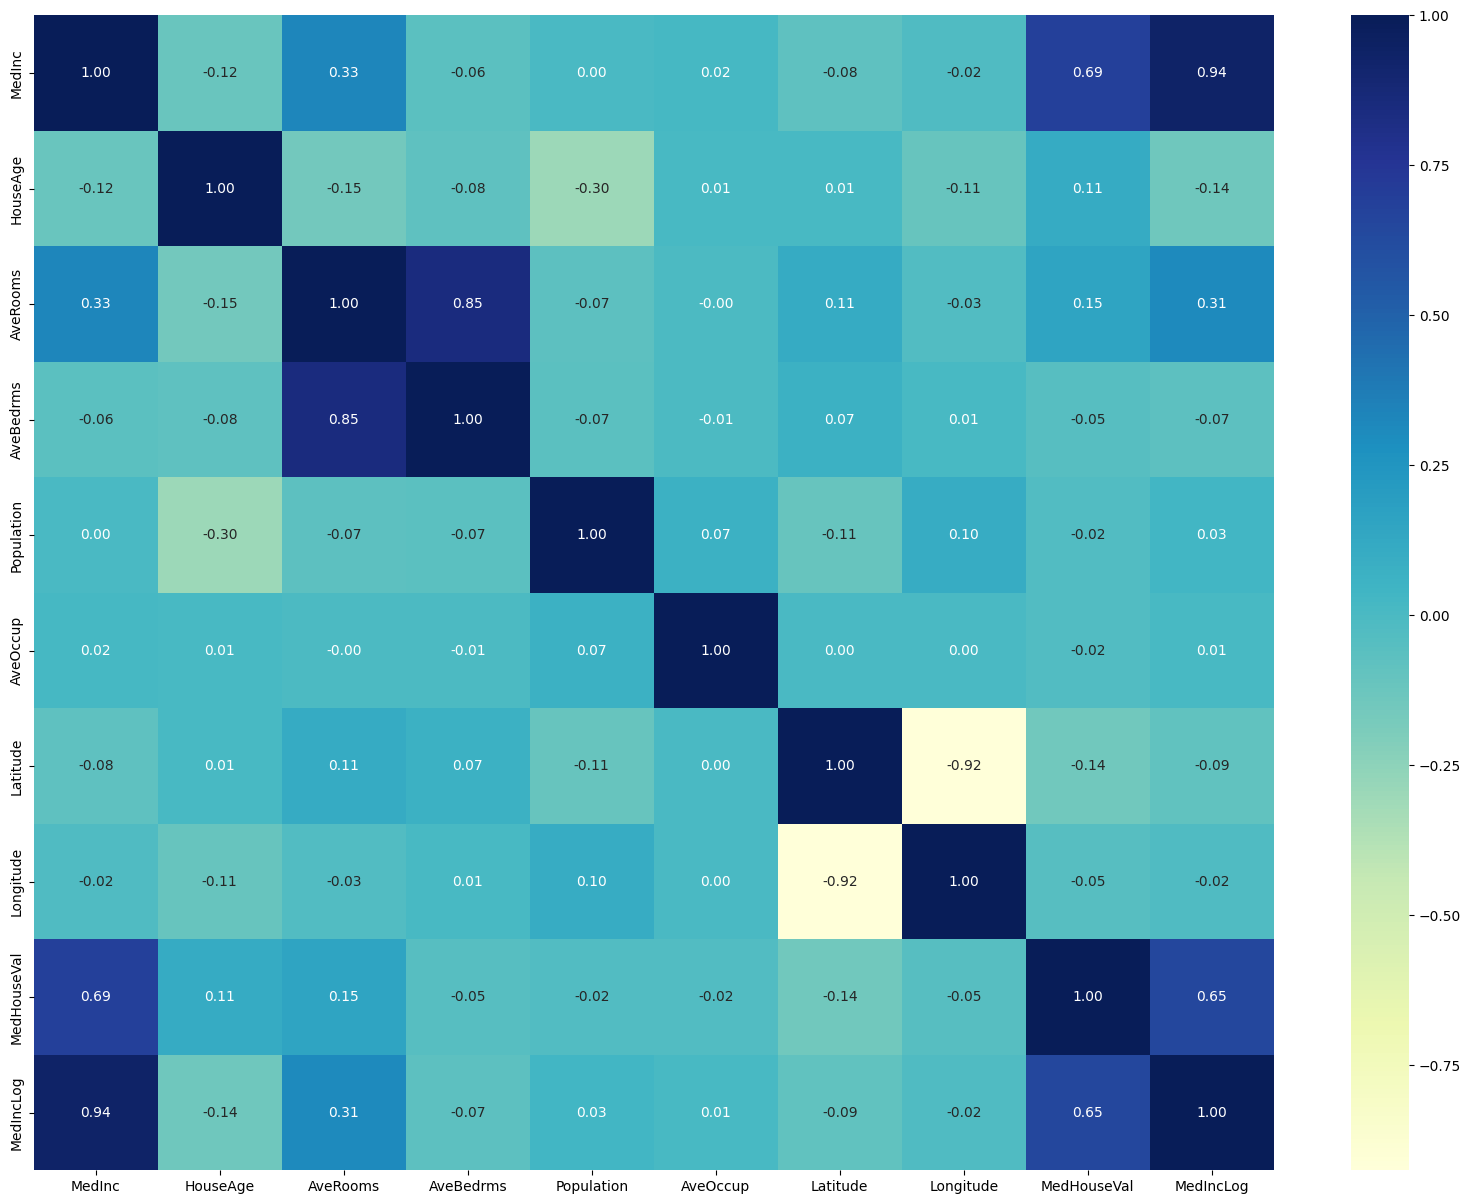

In [296]:
correlation(df['frame'].corr())

После добавления логарифма этого признака получаем корреляцию 0,94 => зависимость не линейная и использование линейного регрессора не имеет особо смысла.

Воспользуемся Random Forest, так как он ловит такие нелинейные зависимости, для большого количества данных он подходит хорошо.

In [297]:
X1, X2, y1, y2 = separating_parts(df['data'], df['target'])

In [298]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 250),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "random_state": 42,
        "n_jobs": -1,
    }
    model = RandomForestRegressor(**params)

    model.fit(X1, y1)

    y_pred = model.predict(X2)

    mae = mean_absolute_error(y2, y_pred)
    return mae

In [299]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2025-09-25 00:08:35,212] A new study created in memory with name: no-name-74846209-6b6d-4bd5-8bf8-a573ae02c586
[I 2025-09-25 00:08:35,574] Trial 0 finished with value: 0.4585178695531143 and parameters: {'n_estimators': 113, 'max_depth': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.4585178695531143.
[I 2025-09-25 00:08:36,279] Trial 1 finished with value: 0.5803991155350752 and parameters: {'n_estimators': 242, 'max_depth': 3, 'max_features': None}. Best is trial 0 with value: 0.4585178695531143.
[I 2025-09-25 00:08:36,904] Trial 2 finished with value: 0.40557989660184596 and parameters: {'n_estimators': 217, 'max_depth': 8, 'max_features': 'log2'}. Best is trial 2 with value: 0.40557989660184596.
[I 2025-09-25 00:08:37,051] Trial 3 finished with value: 0.45871098284968803 and parameters: {'n_estimators': 51, 'max_depth': 7, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.40557989660184596.
[I 2025-09-25 00:08:37,339] Trial 4 finished with value: 0.42883380496881

In [300]:
best_params = study.best_params
model = RandomForestRegressor(**best_params)
model.fit(X1, y1)

,n_estimators,124
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [301]:
y_pred = model.predict(X2)

In [302]:
info(y2, y_pred)

R²: 0.7753804241157725
MAE: 0.3653901754650596
RMSE: 0.5425343389384258


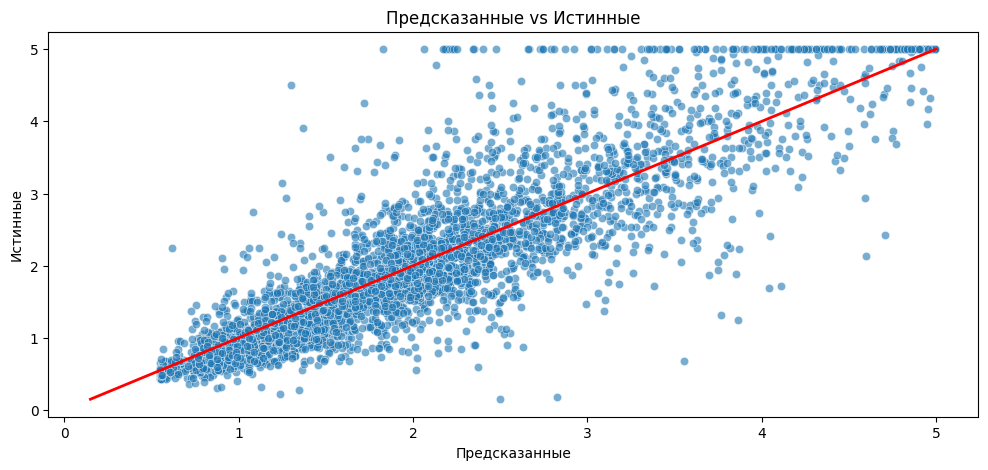

In [303]:
# Предсказанные vs Истинные
plt.figure(figsize=(12, 5))
sns.scatterplot(x=y_pred, y=y2, alpha=0.6)
plt.plot([y2.min(), y2.max()], [y2.min(), y2.max()], 'r', lw=2)
plt.xlabel('Предсказанные')
plt.ylabel('Истинные')
plt.title('Предсказанные vs Истинные')
plt.show()

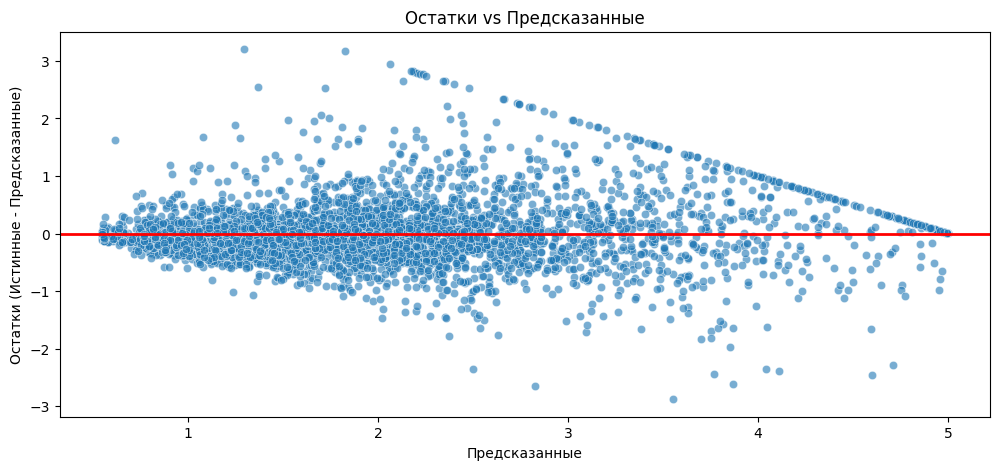

In [304]:
# Остатки vs Предсказанные
plt.figure(figsize=(12, 5))
sns.scatterplot(x=y_pred, y= y2 - y_pred, alpha=0.6)
plt.axhline(0, color='red', lw=2)
plt.xlabel('Предсказанные')
plt.ylabel('Остатки (Истинные - Предсказанные)')
plt.title('Остатки vs Предсказанные')
plt.show()